In [2]:
import os
import time
import torch
import numpy as np

from torch import nn
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from matplotlib import animation

from IPython import display

print(f"Version of torch: {torch.__version__}")
print(f"Version of numpy: {np.__version__}")
print(f"Version of imageio: {imageio.__version__}")

Version of torch: 2.0.1+cu118
Version of numpy: 1.22.4
Version of imageio: 2.25.1


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"This program works on: {device}")

This program works on: cuda


In [4]:
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import torchvision.utils as vutils

from torch.utils.data import Dataset, DataLoader

In [5]:
train_dataset = datasets.FashionMNIST(root="datasets", 
                                     train=True,
                                     download=True,
                                      transform=transforms.ToTensor(),
                                      target_transform=None)

test_dataset = datasets.FashionMNIST(root="./data",
                                     train=False,
                                     download=True,
                                     transform=transforms.ToTensor(),
                                     target_transform=None)

100%|██████████| 26421880/26421880 [00:03<00:00, 8305874.55it/s] 


Extracting datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 139883.75it/s]


Extracting datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2665928.46it/s]


Extracting datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 2287559.80it/s]


Extracting datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 26421880/26421880 [00:03<00:00, 8482202.87it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 140420.53it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2592564.60it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 25797224.60it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [6]:
BATCH_SIZE = 64

In [7]:
dataloader = torch.utils.data.DataLoader(train_dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
real_data_batch = next(iter(dataloader))

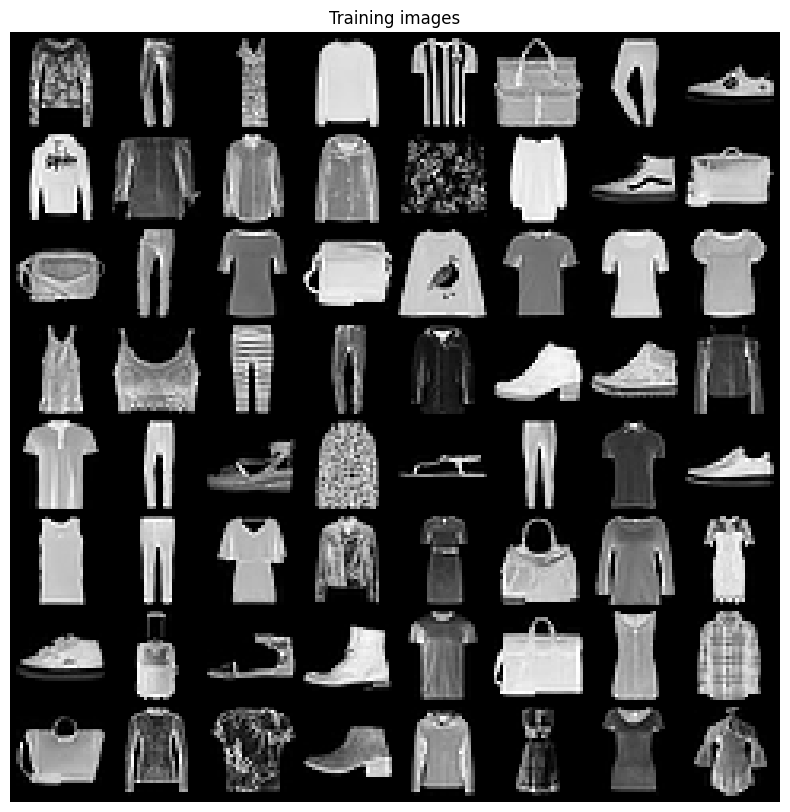

In [8]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title("Training images")
plt.imshow(np.transpose(vutils.make_grid(real_data_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [9]:
classes = train_dataset.classes
print(f"Total training data: {len(train_dataset)} and Total testing data: {len(test_dataset)}")
print(f"Classes: {classes}")

# for total number of batch in training dataset
print(f"{len(train_dataset)} is divided into batches: {len(train_dataset) // BATCH_SIZE}")

Total training data: 60000 and Total testing data: 10000
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
60000 is divided into batches: 937


Sample data shape: torch.Size([1, 28, 28])


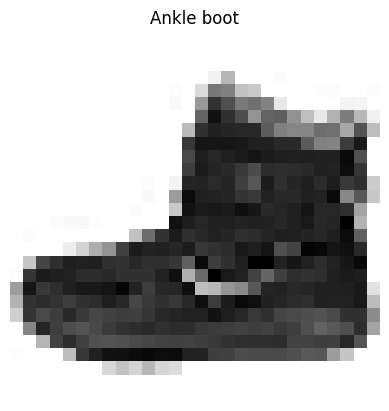

In [10]:
sample_data, sample_label = train_dataset[0]
print(f"Sample data shape: {sample_data.shape}")

fig, ax = plt.subplots()
ax.imshow(sample_data.permute(1, 2, 0), cmap=plt.cm.binary)
ax.set_title(f"{classes[sample_label]}")
ax.axis(False)
plt.show()

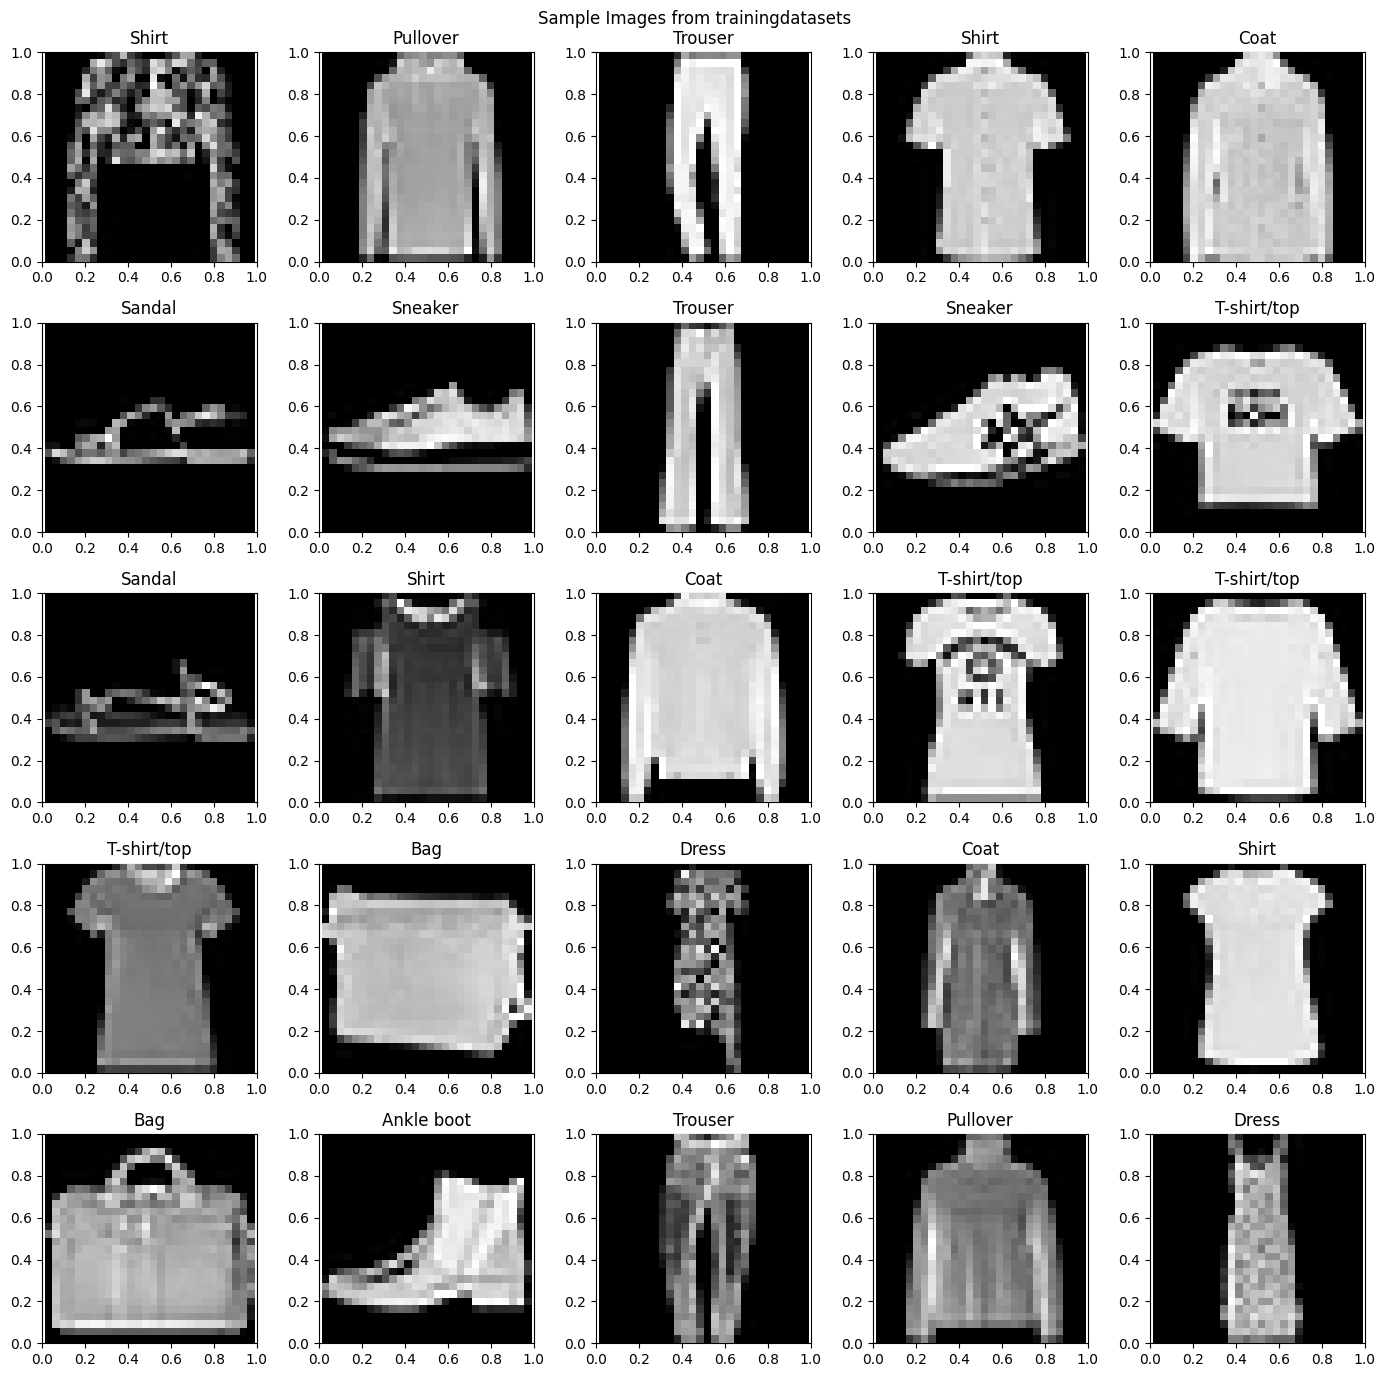

In [11]:
rows = 5
cols = 5

torch.manual_seed(42)
sample_indexes = torch.randint(0, len(train_dataset)-1, [rows*cols])

fig, ax = plt.subplots(rows, cols, figsize=(14, 14))
fig.suptitle("Sample Images from trainingdatasets")
for i in range(rows*cols):

  ax = fig.add_subplot(rows, cols, i+1)
  sample_index = sample_indexes[i]
  # For displaying image purpose.Converting (c, h, w) to (h, w, c)
  image_data = train_dataset[sample_index ][0].permute(1, 2, 0)
  image_class_label = classes[train_dataset[sample_index][1]]
  ax.imshow(image_data, cmap="gray",)
  ax.set_axis_off()
  ax.set_title(f"{image_class_label}")
  
  # ax.plot()
plt.tight_layout()
plt.show()

In [12]:
# custom weight initialization function
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
  elif classname.find("BatchNorm")!= -1:
    nn.init.normal_(m.weight.data, mean=1.0, std=0.02)
    nn.init.constant_(m.bias.data, val=0)

# Shape manipulation
If image size is nxn. Then if convolution operation is performed: New dimension is: 
> O_i = ((W_i + 2P -K)/S)+1
where,

W_i is shape of image

P is Padding

K is Kernel_size

S is stride


---
> For convolution operation , we find O_i when other parameter are given
---
> For convolution Transpose function, we find W_i when other parameter are known

---


In [13]:
class GeneratorModel(nn.Module):
  def __init__(self, input_shape=100, output_channel=1):
    super(GeneratorModel, self).__init__()
    self.sequential_layer = nn.Sequential(
        nn.Linear(in_features=input_shape,
                  out_features=7*7*256,
                  bias=False),
        nn.BatchNorm1d(num_features=7*7*256),
        nn.LeakyReLU(),
        nn.Unflatten(1, (256, 7, 7)),
        nn.ConvTranspose2d(in_channels=256,
                           out_channels=128,
                           kernel_size=5, 
                           padding=2,
                           stride=1,
                           bias=False),
        nn.BatchNorm2d(num_features=128),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(in_channels=128,
                       out_channels=64,
                       kernel_size=4,
                       stride=2,
                       padding=1,
                       bias=False),
        nn.BatchNorm2d(num_features=64),        
        nn.LeakyReLU(),
        nn.ConvTranspose2d(in_channels=64,
                          out_channels=output_channel,
                          kernel_size=4,
                          stride=2,
                          padding=1,
                           bias=False),         
        nn.Tanh()                    
    )                                            

  def forward(self, x: torch.tensor) -> torch.tensor:
    x = self.sequential_layer(x)
    return (x)

In [14]:
generator = GeneratorModel()
generator.to(device)
generator.apply(weights_init)

GeneratorModel(
  (sequential_layer): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=False)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Unflatten(dim=1, unflattened_size=(256, 7, 7))
    (4): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): Tanh()
  )
)

In [15]:
noise = torch.rand(1, 100).to(device)

generator.eval()
generated_image = generator(noise)
generated_image.shape

torch.Size([1, 1, 28, 28])

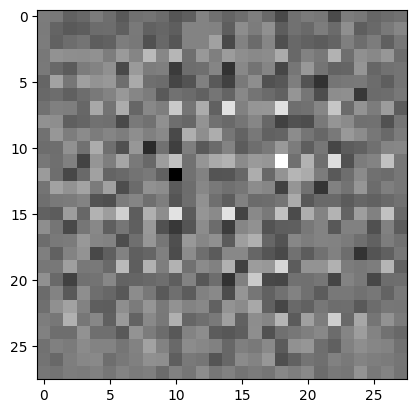

In [16]:
plt.imshow(generated_image[0][0].cpu().detach().numpy(), cmap="gray")
plt.show()

In [55]:
class DiscriminatorModel(nn.Module):
  def __init__(self, input_features=1, hidden_features=10):
    super(DiscriminatorModel, self).__init__()
    """
    Using architeture similar to TinyVGG to construct model

    Args:
      input_feature: Feature of image(Equal to color space avalable in image)

    """
    self.sequential_gen = nn.Sequential(
        nn.Conv2d(in_channels=input_features,
                                 out_channels=hidden_features,
                                 kernel_size=3,
                                 stride=2,
                                 padding=1,
                                 bias=False),
        nn.BatchNorm2d(hidden_features),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=hidden_features,
                                 out_channels=hidden_features,
                                 kernel_size=3,
                                 stride=2,
                                 padding=1,
                                 bias=False),
        nn.BatchNorm2d(hidden_features),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2),  
        nn.Conv2d(in_channels=hidden_features,
                                 out_channels=hidden_features,
                                 kernel_size=3,
                                 stride=2,
                                 padding=1,
                                 bias=False),
        nn.BatchNorm2d(hidden_features),
        nn.LeakyReLU(),  
        nn.Conv2d(in_channels=hidden_features,
                                 out_channels=1,
                                 kernel_size=3,
                                 stride=2,
                                 padding=1,
                                 bias=False), 
        nn.Sigmoid()                                                                                                     
    )

  def forward(self, x: torch.tensor) -> torch.tensor:
    return self.sequential_gen(x)

In [56]:
torch.manual_seed(42)
discriminator = DiscriminatorModel()
discriminator.to(device)
discriminator.apply(weights_init)

DiscriminatorModel(
  (sequential_gen): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(10, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(10, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (11): Sigmoid()
  )
)

In [57]:
ngpu = 1
if device=="cuda" and ngpu > 1:
  discriminator = nn.DataParallel(discriminator, list(range(ngpu)))

In [59]:
learning_rate = 0.0002
beta = 0.5
loss_fn = nn.BCELoss()
optimizer_d = torch.optim.Adam(discriminator.parameters(),
                               lr=learning_rate,
                               betas=(beta, 0.999))
optimizer_g = torch.optim.Adam(generator.parameters(),
                               lr=learning_rate,
                               betas=(beta, 0.999))

In [93]:
# Initialize empty lists to store image samples, generator losses, and discriminator losses
img_list = []
g_losses = []
d_losses = []

# Set the number of epochs and initialize the iteration count
epochs = 5
iters = 0

# Define the labels for real and fake data
real_label = 1
fake_label = 0

# Print information message before starting the training loop
print("[INFO] Starting the training Loop......")

# Training loop
for epoch in tqdm(range(epochs)):
  for i, data in tqdm(enumerate(dataloader, 0)):
    # Reset gradients for the discriminator
    discriminator.zero_grad()
    
    # Move real image batch to the device
    X_image_batch = data[0].to(device)
    b_size = X_image_batch.size(0)
    
    # Create labels for real images
    label = torch.full((b_size,), fill_value=real_label, dtype=torch.float, device=device)
    
    # Forward pass through the discriminator for real images
    output = discriminator(X_image_batch).view(-1)
    real_error_d = loss_fn(output, label)
    real_error_d.backward()
    d_x = output.mean().item()

    # Generate fake images using the generator
    noise_data = torch.randn(b_size, 100, device=device)
    fake_image = generator(noise_data)
    
    # Create labels for fake images
    label.fill_(fake_label)
    
    # Forward pass through the discriminator for fake images
    output = discriminator(fake_image.detach()).view(-1)
    fake_error_d = loss_fn(output, label)
    fake_error_d.backward()
    d_g_x = output.mean().item()

    # Calculate the overall discriminator loss and update the discriminator
    error_d = real_error_d + fake_error_d
    optimizer_d.step()

    # Reset gradients for the generator
    generator.zero_grad()
    
    # Create labels for real images (to be used for generator training)
    label.fill_(real_label)
    
    # Forward pass through the discriminator for fake images (generated by the generator)
    output = discriminator(fake_image).view(-1)
    error_g = loss_fn(output, label)
    error_g.backward()
    d_g_x2 = output.mean().item()
    optimizer_g.step()

    # Print training status
    if i % 100 == 0:
      print(f"[{epoch}/{epochs}] [{i}/{len(dataloader)}]\tLoss_D: {error_d.item():.3f}\tLoss_G: {error_g.item():.3f}")

    # Store generator and discriminator losses
    g_losses.append(error_g.item())
    d_losses.append(error_d.item())

    # Generate and store image samples
    if i % 500 == 0:
      with torch.no_grad():
        fake = generator(noise_data).detach().cpu()
      img_list.append(vutils.make_grid(fake_image, padding=2, normalize=True))
    
    # Increment iteration count
    iters = iters + 1


[INFO] Starting the training Loop......


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

[0/5] [0/938]	Loss_D: 1.334	Loss_G: 0.729
[0/5] [100/938]	Loss_D: 1.396	Loss_G: 0.757
[0/5] [200/938]	Loss_D: 1.444	Loss_G: 0.718
[0/5] [300/938]	Loss_D: 1.346	Loss_G: 0.761
[0/5] [400/938]	Loss_D: 1.389	Loss_G: 0.751
[0/5] [500/938]	Loss_D: 1.405	Loss_G: 0.721
[0/5] [600/938]	Loss_D: 1.346	Loss_G: 0.722
[0/5] [700/938]	Loss_D: 1.390	Loss_G: 0.709
[0/5] [800/938]	Loss_D: 1.452	Loss_G: 0.707
[0/5] [900/938]	Loss_D: 1.386	Loss_G: 0.706


0it [00:00, ?it/s]

[1/5] [0/938]	Loss_D: 1.387	Loss_G: 0.718
[1/5] [100/938]	Loss_D: 1.323	Loss_G: 0.788
[1/5] [200/938]	Loss_D: 1.373	Loss_G: 0.745
[1/5] [300/938]	Loss_D: 1.411	Loss_G: 0.735
[1/5] [400/938]	Loss_D: 1.408	Loss_G: 0.727
[1/5] [500/938]	Loss_D: 1.381	Loss_G: 0.709
[1/5] [600/938]	Loss_D: 1.398	Loss_G: 0.764
[1/5] [700/938]	Loss_D: 1.379	Loss_G: 0.724
[1/5] [800/938]	Loss_D: 1.445	Loss_G: 0.727
[1/5] [900/938]	Loss_D: 1.366	Loss_G: 0.751


0it [00:00, ?it/s]

[2/5] [0/938]	Loss_D: 1.413	Loss_G: 0.685
[2/5] [100/938]	Loss_D: 1.386	Loss_G: 0.716
[2/5] [200/938]	Loss_D: 1.341	Loss_G: 0.738
[2/5] [300/938]	Loss_D: 1.390	Loss_G: 0.749
[2/5] [400/938]	Loss_D: 1.382	Loss_G: 0.745
[2/5] [500/938]	Loss_D: 1.357	Loss_G: 0.760
[2/5] [600/938]	Loss_D: 1.346	Loss_G: 0.737
[2/5] [700/938]	Loss_D: 1.283	Loss_G: 0.866
[2/5] [800/938]	Loss_D: 1.399	Loss_G: 0.684
[2/5] [900/938]	Loss_D: 1.321	Loss_G: 0.795


0it [00:00, ?it/s]

[3/5] [0/938]	Loss_D: 1.387	Loss_G: 0.718
[3/5] [100/938]	Loss_D: 1.396	Loss_G: 0.729
[3/5] [200/938]	Loss_D: 1.356	Loss_G: 0.772
[3/5] [300/938]	Loss_D: 1.386	Loss_G: 0.732
[3/5] [400/938]	Loss_D: 1.350	Loss_G: 0.755
[3/5] [500/938]	Loss_D: 1.413	Loss_G: 0.691
[3/5] [600/938]	Loss_D: 1.367	Loss_G: 0.708
[3/5] [700/938]	Loss_D: 1.441	Loss_G: 0.692
[3/5] [800/938]	Loss_D: 1.411	Loss_G: 0.712
[3/5] [900/938]	Loss_D: 1.392	Loss_G: 0.704


0it [00:00, ?it/s]

[4/5] [0/938]	Loss_D: 1.404	Loss_G: 0.701
[4/5] [100/938]	Loss_D: 1.403	Loss_G: 0.697
[4/5] [200/938]	Loss_D: 1.398	Loss_G: 0.713
[4/5] [300/938]	Loss_D: 1.418	Loss_G: 0.662
[4/5] [400/938]	Loss_D: 1.371	Loss_G: 0.761
[4/5] [500/938]	Loss_D: 1.355	Loss_G: 0.709
[4/5] [600/938]	Loss_D: 1.450	Loss_G: 0.661
[4/5] [700/938]	Loss_D: 1.379	Loss_G: 0.722
[4/5] [800/938]	Loss_D: 1.409	Loss_G: 0.717
[4/5] [900/938]	Loss_D: 1.441	Loss_G: 0.676


In [94]:
# save the model for future use
torch.save(discriminator.state_dict(), "discriminator.pt")
torch.save(discriminator.state_dict(), "generator.pt")

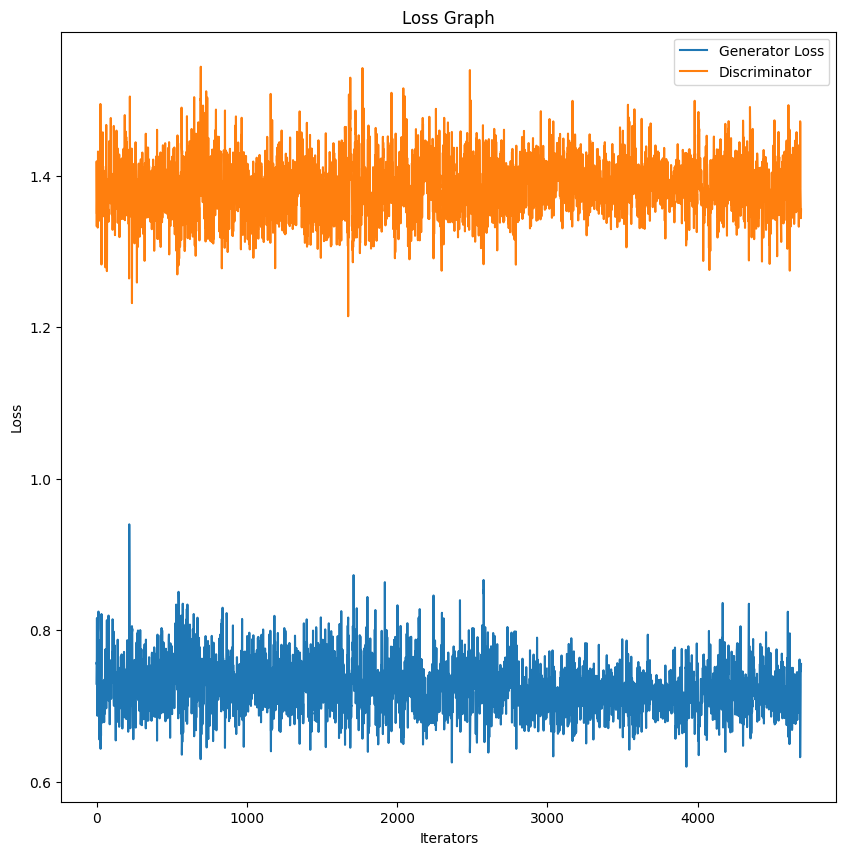

In [95]:
plt.figure(figsize=(10, 10))
plt.title("Loss Graph")
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator")
plt.ylabel("Loss")
plt.xlabel("Iterators")
plt.legend()
plt.show()

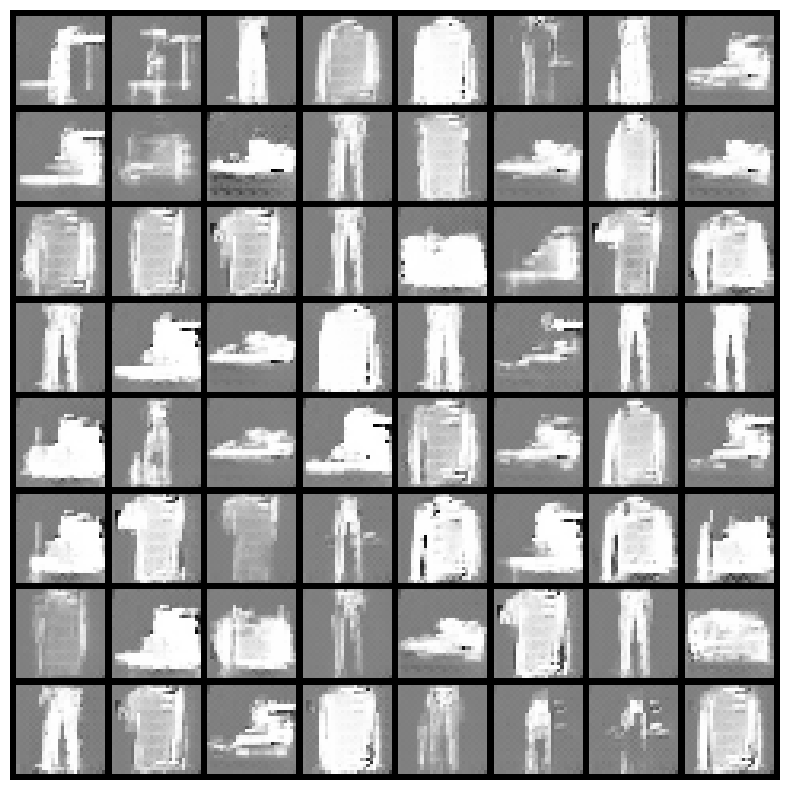

In [96]:
fig = plt.figure(figsize=(10, 10))
plt.axis(False)
ims = [[plt.imshow(np.transpose(i.cpu(), (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
display.HTML(ani.to_jshtml())

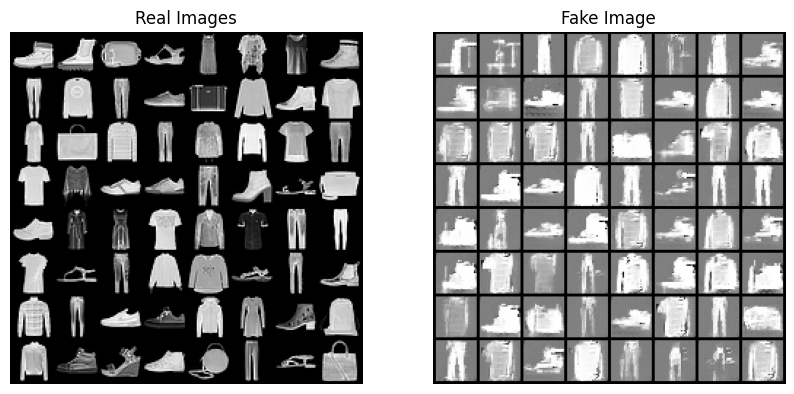

In [97]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.axis(False)
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],
                                         padding=2, normalize=True).cpu(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis(False)
plt.title("Fake Image")
plt.imshow(np.transpose(img_list[-1].cpu(), (1,2, 0)))

plt.show()